# BLNK Analysis Pipeline
This notebook serves an interactive means to operate the BLNK extraction pipeline. Following the steps below, 
one may analyze videos of the eye and extract pupil and eyelids information therefrom, outputting the 
result as a MATLAB file. 

## Step 1: Environment Setup and Library Imports
To use the pipeline, one must first install [Pylids](https://github.com/piecesofmindlab/pylids), which is attached as a submodule to this GitHub repo. 
Follow their installation instructions first. This will generate a pylids conda environment you will use as the basis for this project into which
we will install further libraries.  

### Ensuring Correct Kernel
To ensure you are using the correct pylids kernel, we will first import some standard library functions to check 
the name of the kernel you are using and assert it is the correct one

In [1]:
import os 
import sys
import pathlib
import pickle as pkl
import importlib
from natsort import natsorted
conda_kernel_name: str | None = os.environ.get("CONDA_DEFAULT_ENV")
assert conda_kernel_name == "pylids", f"Conda environment: {conda_kernel_name} is not equal to pylids"

### Installing Additional Libraries. 
After the pylids conda environment has been created, we have to also install 
additional libraries into that environment used by this project 

In [ ]:
%pip install pupil-detectors
%pip install pye3d
%pip install natsort 
%pip install hdf5storage
%pip install scipy 
%pip install dill
%pip install h5py

### Import Custom Libraries
Next, we will import the custom libraries written to do the analysis for this pipeline

In [2]:
# Define the path to the top level of htis repo 
blnk_analysis_dir: str = "/Users/zacharykelly/Documents/MATLAB/projects/BLNK_pipeline"
assert os.path.exists(blnk_analysis_dir), f"Path: {blnk_analysis_dir} does not exist"
sys.path.append(blnk_analysis_dir)

from utility import video_io
from blnk_analysis_code.utility import blnk_analysis_pipeline

Loading DLC 3.0.0rc8...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


## Step 2: Gather Paths to Videos for Analysis
Now that our libraries are properly installed, we will not gather the path(s) to the videos that 
we would like to analyze

In [3]:
# First, we will initialize the list of videos we want to analyze. 
# We will populate this list with either a single path or many paths later 
videos_to_analyze: list[str] = []

In [4]:
# If you want to analyze a directory of videos, simply enter the path to that directory here 
video_directory_path: str = "/Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/BLNK_raw/PuffLight/modulate/BLNK_1003"
videos_to_analyze.extend([os.path.join(video_directory_path, filename) 
                          for filename in os.listdir(video_directory_path) if filename.endswith(".avi")]
                        )

In [5]:
# Next, we will assert that all paths are unique, exist and can be accessed (e.g. ensure they are local files if the directory is on DropBox)
unique_videos_to_analyze: dict[str, None] = {video: None 
                                             for video in videos_to_analyze
                                            } # We use a dictionary to preserve order as compared to set

# After we have asserted that all of the videos are unique, let's ensure the paths exist and they can be accessed 
for path in unique_videos_to_analyze:
    assert os.path.exists(path), f"Path does not exist: {path}"
    try:
        assert video_io.inspect_video_frame_count(path) != 0, f"Frame count for path: {path} is 0" 
    except:
        raise Exception(f"Cannot count frames for path: {path}. Check if the file is corrupted/online-only?")
    
# Reassign videos to analyze to be the unique set 
videos_to_analyze = [video for video, _ in unique_videos_to_analyze.items()]
assert len(videos_to_analyze) != 0, f"No videos to analyze"

## Step 3: Defining Output Location
Next, we will define where the output of the analysis of the desired videos should be placed. 

In [8]:
# Generate output folder 
output_folder_path: str = video_directory_path.replace("BLNK_raw", "BLNK_analysis")
os.makedirs(output_folder_path, exist_ok=True)
assert os.path.exists(output_folder_path)
print(f"Outputting to {output_folder_path}")

Outputting to /Users/zacharykelly/Aguirre-Brainard Lab Dropbox/Zachary Kelly/BLNK_analysis/PuffLight/modulate/BLNK_1003


## Step 4: Analyze Videos 
Now, we will analyze the desired videos. Doing so involves an intermediate step of modifying the video 
video cropping and then padding to a certain size, while also blacking out overly white pixels. Before analyzing, we must define the values of these parameters.

### Parameter Declaration

First, we will define the aforementioned constant parameters

In [9]:
# Define the image manipulation parameters 
crop_ellipse: dict = {"center": (150, 100), "axes": (135, 80), "ang_deg": 0}
target_size: tuple = (480, 640)
whiteness_threshold: int = 255
contrast: float = 1.2
brightness: float = 0
gamma: float = 1.5

# We will save some information about the settings used for the subject
path_to_subject_settings_dir: str = "/Users/zacharykelly/Documents/MATLAB/projects/BLNK_pipeline/subject_settings"
subject_settings_filepath: str = os.path.join(path_to_subject_settings_dir, os.path.basename(video_directory_path) + ".pkl")
subject_settings_dict: dict = {"crop_ellipse": crop_ellipse,
                               "target_size": target_size,
                               "whiteness_threshold": whiteness_threshold,
                               "contrast": contrast,
                               "brightness": brightness,
                               "gamma": gamma
                            }

with open(subject_settings_filepath,"wb") as f:
    pkl.dump(subject_settings_dict, f)


# Generate a temp output directory for the intermediate stage videos
temp_dir_path: str = '/Users/zacharykelly/Desktop'
if(not os.path.exists(temp_dir_path)):
    os.mkdir(temp_dir_path)


### Parameter Verification
TODO: Explain this

Processing video: 1/2


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 19.1.7
  configuration: --prefix=/opt/anaconda3/envs/pylids --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1753272244790/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libvo

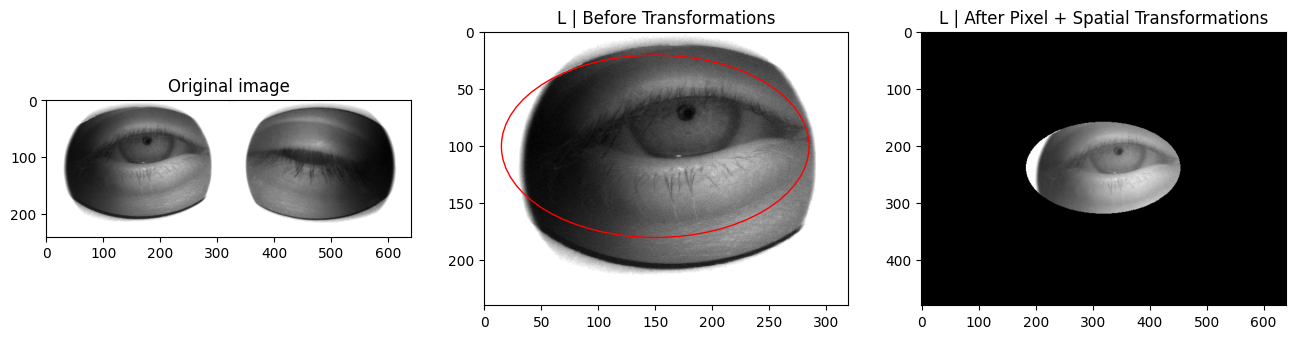

Model weights already exist!
Analyzing videos with /Users/zacharykelly/Library/Application Support/pylids/pytorch-pupil-v1/dlc-models-pytorch/iteration-0/santini_eyelid_detectionJul182025-trainset99shuffle1/train/snapshot-best-220.pt
Starting to analyze /Users/zacharykelly/Desktop/temp_BLNK_1003_modulate_adapt-06_L.avi
Video metadata: 
  Overall # of frames:    500
  Duration of video [s]:  2.78
  fps:                    180.0
  resolution:             w=640, h=480

Running pose prediction with batch size 8


100%|██████████| 500/500 [00:16<00:00, 29.82it/s]


Saving results in /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp5tfjw2kx/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220.h5 and /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp5tfjw2kx/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

['/var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp5tfjw2kx/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220.h5']
Model weights already exist!
Analyzing videos with /Users/zacharykelly/Library/Application Support/pylids/pytorch-eyelid-v1/dlc-models-pytorch/iteration-0/sant

100%|██████████| 500/500 [00:22<00:00, 22.51it/s]


Saving results in /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmpkx1sk_8y/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110.h5 and /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmpkx1sk_8y/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

['/var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmpkx1sk_8y/temp_BLNK_1003_modulate_adapt-06_LDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110.h5']


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with clang version 19.1.7
  configuration: --prefix=/opt/anaconda3/envs/pylids --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1753272244790/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libmp3lame --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libvo

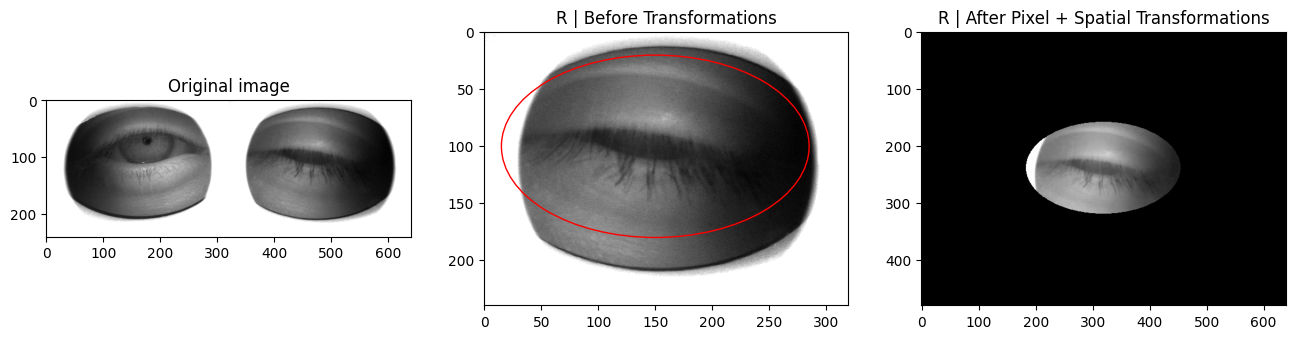

Model weights already exist!
Analyzing videos with /Users/zacharykelly/Library/Application Support/pylids/pytorch-pupil-v1/dlc-models-pytorch/iteration-0/santini_eyelid_detectionJul182025-trainset99shuffle1/train/snapshot-best-220.pt
Starting to analyze /Users/zacharykelly/Desktop/temp_BLNK_1003_modulate_adapt-06_R.avi
Video metadata: 
  Overall # of frames:    500
  Duration of video [s]:  2.78
  fps:                    180.0
  resolution:             w=640, h=480

Running pose prediction with batch size 8


100%|██████████| 500/500 [00:16<00:00, 29.93it/s]


Saving results in /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp7ymbu7oo/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220.h5 and /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp7ymbu7oo/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

['/var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp7ymbu7oo/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_220.h5']
Model weights already exist!
Analyzing videos with /Users/zacharykelly/Library/Application Support/pylids/pytorch-eyelid-v1/dlc-models-pytorch/iteration-0/sant

100%|██████████| 500/500 [00:22<00:00, 22.43it/s]


Saving results in /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp92gxez94/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110.h5 and /var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp92gxez94/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110_full.pickle
The videos are analyzed. Now your research can truly start!
You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.

['/var/folders/g_/1p95771n5l1f_f8gbbftkjy80000gn/T/tmp92gxez94/temp_BLNK_1003_modulate_adapt-06_RDLC_Resnet50_santini_eyelid_detectionJul182025shuffle1_snapshot_110.h5']
Processing video: 2/2


In [ ]:
importlib.reload(blnk_analysis_pipeline)

# First, we will visualize the first few seconds of only a few dark and adapt videos
# from each DATE for this participant to 

adapt_verification_videos: list[str] = [filepath
                                        for filepath in videos_to_analyze 
                                        if "adapt" in os.path.basename(filepath.rstrip("/"))
                                       ][::4]
dark_verification_videos: list[str] = [filepath
                                       for filepath in videos_to_analyze 
                                       if "dark" in os.path.basename(filepath.rstrip("/")) 
                                      ][::4] 

verification_videos: list[str] = adapt_verification_videos + dark_verification_videos

# Iterate over the videos and output them to the target directory 
for video_num, video_path in enumerate(verification_videos):
    print(f"Processing video: {video_num+1}/{len(verification_videos)}", flush=True)

    # Determine if we should visiualize the results.
    # That is, we will only visualize dark and adapt videos 
    video_name: str = os.path.basename(video_path.rstrip("/"))
    blnk_analysis_pipeline.predict_eye_features(video_path, output_folder_path, crop_ellipse, target_size, temp_dir_path, 
                                                threshold_value=whiteness_threshold,
                                                visualize_results=True,
                                                overrwrite_existing=True,
                                                debug_mode=True,
                                                contrast=contrast,
                                                gamma=gamma,
                                                brightness=brightness
                                               )



### Analysis
Once you are satisfied with the above parameters , we can move onto analyzing the target video

In [ ]:
importlib.reload(blnk_analysis_pipeline)

# Iterate over the videos and output them to the target directory 
for video_num, video_path in enumerate(videos_to_analyze):
    print(f"Processing video: {video_num+1}/{len(videos_to_analyze)}", flush=True)

    # Determine if we should visiualize the results.
    # That is, we will only visualize dark and adapt videos 
    video_name: str = os.path.basename(video_path.rstrip("/"))
    blnk_analysis_pipeline.predict_eye_features(video_path, output_folder_path, crop_ellipse, target_size, temp_dir_path, 
                                                threshold_value=whiteness_threshold,
                                                visualize_results=False,
                                                overrwrite_existing=True,
                                                debug_mode=False,
                                                contrast=contrast,
                                                gamma=gamma,
                                                brightness=brightness
                                               )

    